<a target="_blank" href="https://colab.research.google.com/github/arindamchoudhury/ml-projects/blob/main/MNIST_Handwritten_Digits.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction

In this project, we will build a neural network of to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)



## Imports

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import multiprocessing

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load the Dataset

In [21]:
# Define transforms
# https://nextjournal.com/gkoehler/pytorch-mnist Normalize params 
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
            ])

# Create training set and define training dataloader
training_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

## Let's keep 80% of the training data for training
train_len = int(len(training_dataset) * 0.8)

## Let's use the remaining for validation
val_len = len(training_dataset) - train_len

train_dataset, valid_dataset = torch.utils.data.random_split(training_dataset, [train_len, val_len])

# Create test set and define test dataloader
batch_size = 64
num_workers = multiprocessing.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

## Explore the Dataset


In [22]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

3


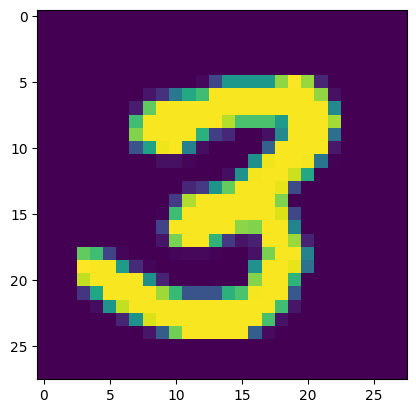

3


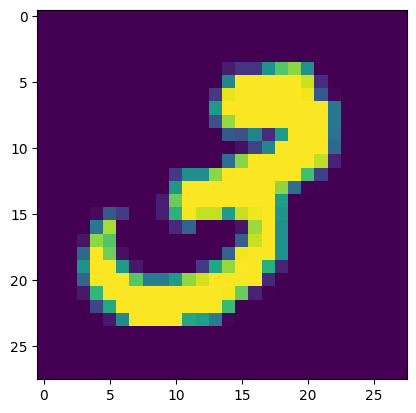

8


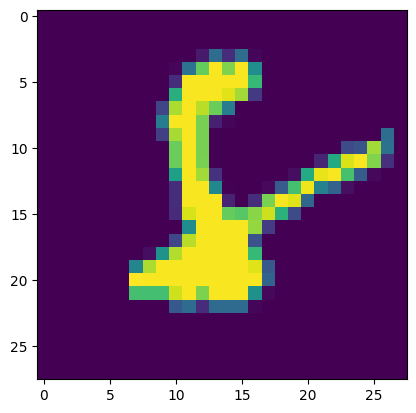

4


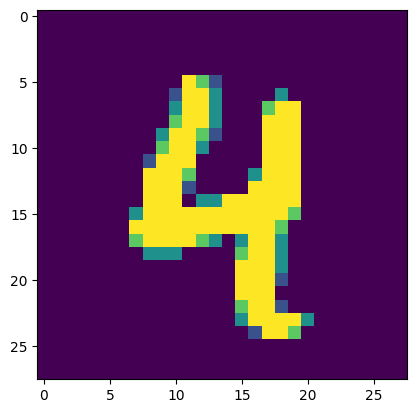

7


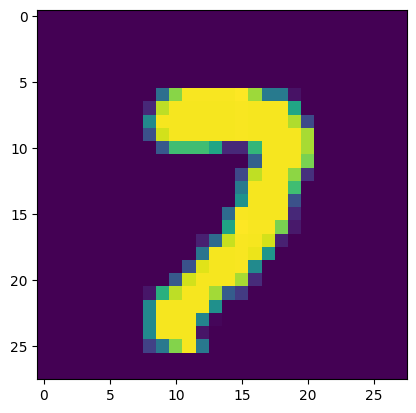

In [23]:
# Explore data
show5(train_loader)

## Build the Model

In [24]:
# base of the LeNet5 collected from https://github.com/rgkannan676/MNIST-Handwritten-Digit-Recognition/blob/main/OptmizerSelection.py
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.relu3 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(120)
        
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.relu4 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(84)
        
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')        
        self.relu5 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_bn(out)
        out = self.relu1(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.conv2_bn(out)
        out = self.relu2(out)
        out = self.pool2(out)

        out = out.view(-1,16*5*5)

        out = self.fc1(out)
        out = self.relu3(out)
        out = self.bn1(out)

        out = self.fc2(out)
        out = self.relu4(out)
        out = self.bn2(out)

        out = self.fc3(out)
        return out
    
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu5): ReLU()
)

In [25]:
scripted = torch.jit.script(net)
torch.jit.save(scripted, "visualize_model.pt")
# open in neutron.app to visualize the model

## Running the Model

In [26]:
def accuracy(logits, labels):
    _, yhat = torch.max(logits.data, dim=1)
    equals = yhat == labels
    return torch.mean(equals.type(torch.FloatTensor))

In [27]:
# collected from https://www.coursera.org/projects/pneumonia-classification-using-pytorch
class ModelTrainer():
    def __init__(self, criterion = None, optimizer = None):        
        self.criterion = criterion
        self.optimizer = optimizer
  
    def train_batch_loop(self, model, trainloader):        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader):            
            images = images.to(device)
            labels = labels.to(device)
            
            self.optimizer.zero_grad()
            logits = model(images)
            loss = self.criterion(logits, labels)
                        
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self, model, validloader):        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):                
            images = images.to(device)
            labels = labels.to(device)
             
            logits = model(images)
            loss = self.criterion(logits, labels)
              
            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs, filename):        
        valid_min_loss = np.Inf
        train_loss_history = list()
        valid_loss_history = list()
        
        for i in range(epochs):            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)
            train_loss_history.append(avg_train_loss)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, validloader)
            valid_loss_history.append(avg_valid_loss)
            
            if avg_valid_loss < valid_min_loss:
                print(f"validation loss decreased {valid_min_loss} --> {avg_valid_loss}")
                torch.save(model.state_dict(), filename)
                valid_min_loss = avg_valid_loss

                
            print(f"Epoch : {i+1} Train Loss : {avg_train_loss:.6f} Train Acc : {avg_train_acc:.6f}")
            print(f"Epoch : {i+1} Valid Loss : {avg_valid_loss:.6f} Valid Acc : {avg_valid_acc:.6f} Min Loss : {valid_min_loss:.6f}")
        
        return train_loss_history, valid_loss_history

In [28]:
optimizer =  optim.Adam(net.parameters(), lr=0.003, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

trainer = ModelTrainer(criterion, optimizer)
train_loss_history, valid_loss_history = trainer.fit(model=net, trainloader=train_loader, validloader=valid_loader, epochs=20, filename="leNet.pt")

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

validation loss decreased inf --> 0.6211854054572734
Epoch : 1 Train Loss : 0.504285 Train Acc : 0.942750
Epoch : 1 Valid Loss : 0.621185 Valid Acc : 0.962018 Min Loss : 0.621185


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

validation loss decreased 0.6211854054572734 --> 0.5307377190031903
Epoch : 2 Train Loss : 0.543214 Train Acc : 0.957146
Epoch : 2 Valid Loss : 0.530738 Valid Acc : 0.954289 Min Loss : 0.530738


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.529092 Train Acc : 0.959188
Epoch : 3 Valid Loss : 0.638053 Valid Acc : 0.935672 Min Loss : 0.530738


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.523202 Train Acc : 0.959104
Epoch : 4 Valid Loss : 0.550502 Valid Acc : 0.938165 Min Loss : 0.530738


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.515493 Train Acc : 0.959979
Epoch : 5 Valid Loss : 0.665749 Valid Acc : 0.917636 Min Loss : 0.530738


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.512919 Train Acc : 0.960333
Epoch : 6 Valid Loss : 0.533417 Valid Acc : 0.967586 Min Loss : 0.530738


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

validation loss decreased 0.5307377190031903 --> 0.5125244893926255
Epoch : 7 Train Loss : 0.509383 Train Acc : 0.961125
Epoch : 7 Valid Loss : 0.512524 Valid Acc : 0.957197 Min Loss : 0.512524


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.507402 Train Acc : 0.960625
Epoch : 8 Valid Loss : 0.552970 Valid Acc : 0.939910 Min Loss : 0.512524


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

validation loss decreased 0.5125244893926255 --> 0.4839665965831026
Epoch : 9 Train Loss : 0.504988 Train Acc : 0.960979
Epoch : 9 Valid Loss : 0.483967 Valid Acc : 0.945312 Min Loss : 0.483967


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

validation loss decreased 0.4839665965831026 --> 0.47774246731337083
Epoch : 10 Train Loss : 0.507962 Train Acc : 0.960187
Epoch : 10 Valid Loss : 0.477742 Valid Acc : 0.966007 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.503645 Train Acc : 0.961542
Epoch : 11 Valid Loss : 0.587561 Valid Acc : 0.947640 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.511330 Train Acc : 0.960083
Epoch : 12 Valid Loss : 0.562404 Valid Acc : 0.938497 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.512368 Train Acc : 0.958833
Epoch : 13 Valid Loss : 0.523600 Valid Acc : 0.956117 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.507991 Train Acc : 0.960063
Epoch : 14 Valid Loss : 0.557451 Valid Acc : 0.957862 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.505821 Train Acc : 0.961708
Epoch : 15 Valid Loss : 0.540807 Valid Acc : 0.949801 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.508589 Train Acc : 0.959500
Epoch : 16 Valid Loss : 0.642513 Valid Acc : 0.946060 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.510263 Train Acc : 0.960521
Epoch : 17 Valid Loss : 0.618094 Valid Acc : 0.933594 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.506160 Train Acc : 0.961167
Epoch : 18 Valid Loss : 0.541777 Valid Acc : 0.955369 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.508798 Train Acc : 0.960208
Epoch : 19 Valid Loss : 0.488624 Valid Acc : 0.922706 Min Loss : 0.477742


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.507040 Train Acc : 0.960938
Epoch : 20 Valid Loss : 0.523285 Valid Acc : 0.953291 Min Loss : 0.477742


Plot the training loss and validation loss/accuracy:

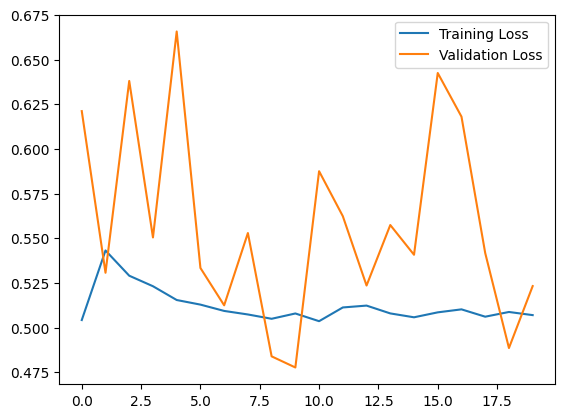

In [29]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(valid_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing the model


In [30]:
test_net = LeNet5()
test_net.to(device)
test_net.load_state_dict(torch.load('leNet.pt'))
test_net.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(test_net, test_loader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss : 0.47030919676373717
Test Acc : 0.9672571420669556


## Saving model

In [31]:
torch.save(net.state_dict(), "LeNetFinal.pt")